https://github.com/thu-ml/zhusuan/blob/master/examples/bayesian_neural_nets/bayesian_nn.py

In [5]:
import numpy as np
import edward as ed
import matplotlib.pyplot as plt

In [6]:
import seaborn as sns

In [7]:
import numpy as np
import tensorflow as tf

from edward.models import Normal, Empirical

In [8]:
ed.set_seed(12)
sns.set()
%matplotlib inline

In [9]:
# Our model will be a two-layer neural network.
def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.matmul(x, W_0) + b_0
    h = tf.tanh(h)
    #h = tf.exp(tf.negative(tf.square(h)))
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

def display_draws(x_data, y_data, draw_inputs, draw_outputs, label):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    ax.plot(x_data, y_data, 'ks', alpha=0.5, label='(x, y)')
    ax.plot(draw_inputs, draw_outputs[0].T, 'r', lw=2, alpha=0.5, label=label)
    ax.plot(draw_inputs, draw_outputs[1:].T, 'r', lw=2, alpha=0.5)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-2, 3])
    ax.legend()
    plt.show()

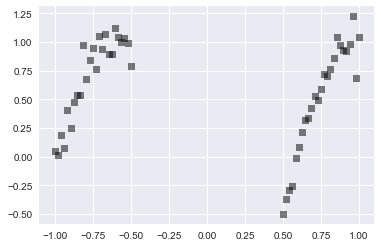

In [10]:
x_train = np.concatenate([np.linspace(0, 2, num=25),
                           np.linspace(6, 8, num=25)])
y_train = np.sin(x_train) + np.random.normal(0, 0.1, size=50)
x_train = (x_train - 4.0) / 4.0
x_train = x_train.reshape((50,1))

plt.plot(x_train, y_train, 'ks', alpha=0.5)

In [11]:
# Build a Bayesian Neural Network with normal priors over weights
W_0 = Normal(loc=tf.zeros([1, 20]), scale=tf.ones([1, 20]))
W_1 = Normal(loc=tf.zeros([20, 1]), scale=tf.ones([20, 1]))
b_0 = Normal(loc=tf.zeros(20), scale=tf.ones(20))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = tf.placeholder(tf.float32, (50,1))
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1), scale=0.1*tf.ones(50))

In [12]:
# Posterior approximators
qW_0 = Normal(loc=tf.Variable(tf.random_normal([1, 20])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1, 20]))))
qW_1 = Normal(loc=tf.Variable(tf.random_normal([20, 1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([20, 1]))))
qb_0 = Normal(loc=tf.Variable(tf.random_normal([20])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([20]))))
qb_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

In [17]:
# Sample neural networks from our variational model.
rs = np.random.RandomState(0)
inputs = np.linspace(-5, 5, num=500, dtype=np.float32)
nx = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [neural_network(nx, qW_0.sample(), qW_1.sample(), qb_0.sample(), qb_1.sample())
     for _ in range(4)])

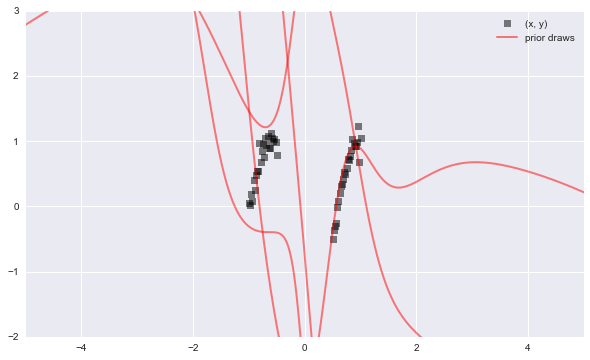

In [18]:
# Visualize prior draws.
sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()
display_draws(x_train, y_train, inputs, outputs, 'prior draws')

In [19]:
# Training: Minimize the KL-divergence of our posterior approximators.
inference = ed.KLqp({W_0: qW_0, b_0: qb_0, W_1: qW_1, b_1: qb_1},
                    data={x: x_train, y: y_train})

In [20]:
inference.initialize()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [28]:
import sys
from tqdm import tqdm

In [34]:
N = 7000
train_x, test_x = data_x[:N], data_x[N:]
train_y, test_y = data_y[:N], data_y[N:]

in_size = train_x.shape[1]
out_size = train_y.shape[1]

EPOCH_NUM = 5
BATCH_SIZE = 1000

# for bayesian neural network
train_y2 = np.argmax(train_y, axis=1)
test_y2 = np.argmax(test_y, axis=1)

In [35]:
with sess:
    samples_num = 100
    for epoch in tqdm(range(EPOCH_NUM), file=sys.stdout):
        perm = np.random.permutation(N)
        for i in range(0, N, BATCH_SIZE):
            batch_x = x_train[perm[i:i+BATCH_SIZE]]
            batch_y = y_train[perm[i:i+BATCH_SIZE]]
            inference.update(feed_dict={x_: batch_x, y_: batch_y})
        y_samples = y.sample(samples_num).eval(feed_dict={x_: x_train})
        acc = (np.round(y_samples.sum(axis=0) / samples_num) == y_train).mean()
        y_samples = y.sample(samples_num).eval(feed_dict={x_: test_x})
        test_acc = (np.round(y_samples.sum(axis=0) / samples_num) == test_y2).mean()
        if (epoch+1) % 1 == 0:
            tqdm.write('epoch:\t{}\taccuracy:\t{}\tvaridation accuracy:\t{}'.format(epoch+1, acc, test_acc))

  0%|          | 0/5 [00:00<?, ?it/s]


NameError: name 'x_' is not defined

In [ ]:
# Compute the gradients for a list of variables.
grads_and_vars = opt.compute_gradients(loss, <list of variables>)

# grads_and_vars is a list of tuples (gradient, variable).  Do whatever you
# need to the 'gradient' part, for example cap them, etc.
capped_grads_and_vars = [(MyCapper(gv[0]), gv[1]) for gv in grads_and_vars]

# Ask the optimizer to apply the capped gradients.
opt.apply_gradients(capped_grads_and_vars)